In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import time
from joblib import dump

dataFrame = pd.read_csv('../dataset/CrimeDataset.csv')



In [2]:
def scale_ranking(value, old_min, old_max, new_min, new_max):
  
  if old_min == old_max:
    return new_min 
  return ((value - old_min) * (new_max - new_min)) / (old_max - old_min) + new_min

old_max_sex = 2
old_max_age = 5
old_max_descent = 18
old_max_area = 20
old_max_time = 3
new_max = 5 

# Scaled rankings
scaled_sex_ranking = scale_ranking(dataFrame['Sex-Crime Ranking'], 0, old_max_sex, 1, new_max)
scaled_age_ranking = scale_ranking(dataFrame['Age-Crime Ranking'], 0, old_max_age, 1, new_max)
scaled_descent_ranking = scale_ranking(dataFrame['Descent-Crime Ranking'], 0, old_max_descent, 1, new_max)
scaled_area_ranking = scale_ranking(dataFrame['Area-Crime Ranking'], 0, old_max_area, 1, new_max)
scaled_time_ranking = scale_ranking(dataFrame['Time-Crime Ranking'], 0, old_max_time, 1, new_max) 

Crime_Likelihood_Value= (scaled_age_ranking+scaled_area_ranking+scaled_descent_ranking+scaled_sex_ranking+scaled_time_ranking)/25

crime_likelihood_ranges = {
    'Very Low': (0.0, 0.3),
    'Low': (0.3,0.5),
    'Medium': (0.5,0.7),
    'High': (0.7,0.85),
    'Very High': (0.85, 1.0)
}


def assign_crime_likelihood(value):
    for category, range in crime_likelihood_ranges.items():
        if range[0]<= value <= range[1]:
            return category
    return None
dataFrame['Crime Likelihood Range'] = Crime_Likelihood_Value.apply(assign_crime_likelihood)

dataFrame['Crime Likelihood Range'] = dataFrame['Crime Likelihood Range'].astype('category')

dataFrame['Crime Likelihood Percentage'] = round(Crime_Likelihood_Value*100 , 2)

In [3]:
'''KNN Model'''

#features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y = dataFrame['Crime Likelihood Range']


#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

start_time = time.time()
#Training KNN Model
k=5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train,Y_train)

#Predictions on Testing data
Y_pred_KNN = knn_model.predict(X_test)

execution_time_KNN = time.time() - start_time
print("Execution Time:", execution_time_KNN, "seconds")

#Evaluating performance
accuracy_KNN = accuracy_score(Y_test, Y_pred_KNN)
precision_KNN = precision_score(Y_test, Y_pred_KNN, average="weighted", zero_division=0)  
recall_KNN = recall_score(Y_test, Y_pred_KNN, average="weighted", zero_division=0) 
f1_KNN = f1_score(Y_test, Y_pred_KNN, average="weighted")
print("KNN Accuracy: ", accuracy_KNN)
print("KNN Precision: ", precision_KNN)
print("KNN Recall: ", recall_KNN)
print("KNN F1: ", f1_KNN)


Execution Time: 7.544476270675659 seconds
KNN Accuracy:  0.998669211327178
KNN Precision:  0.9986665980222098
KNN Recall:  0.998669211327178
KNN F1:  0.9986666311875148


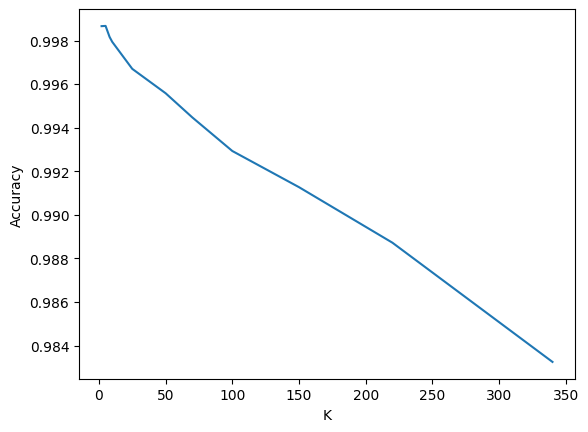

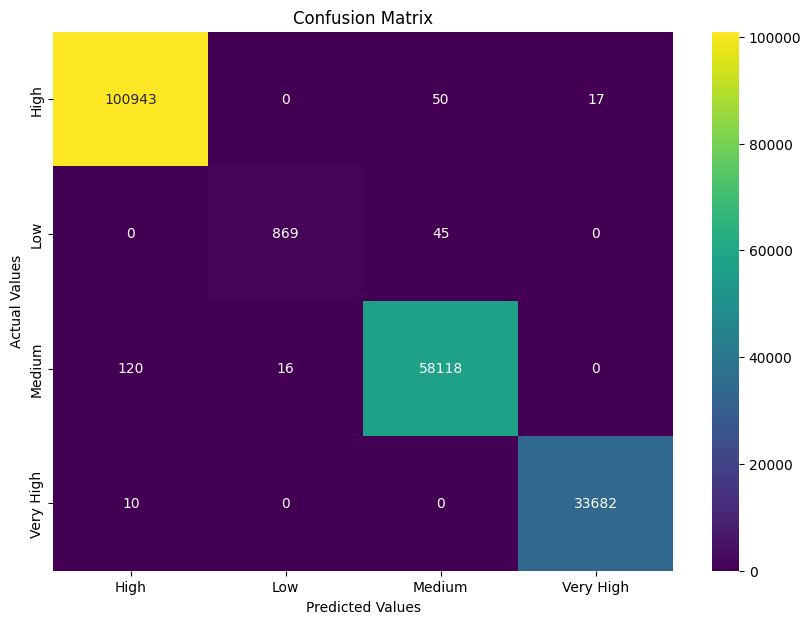

<Figure size 1200x1200 with 0 Axes>

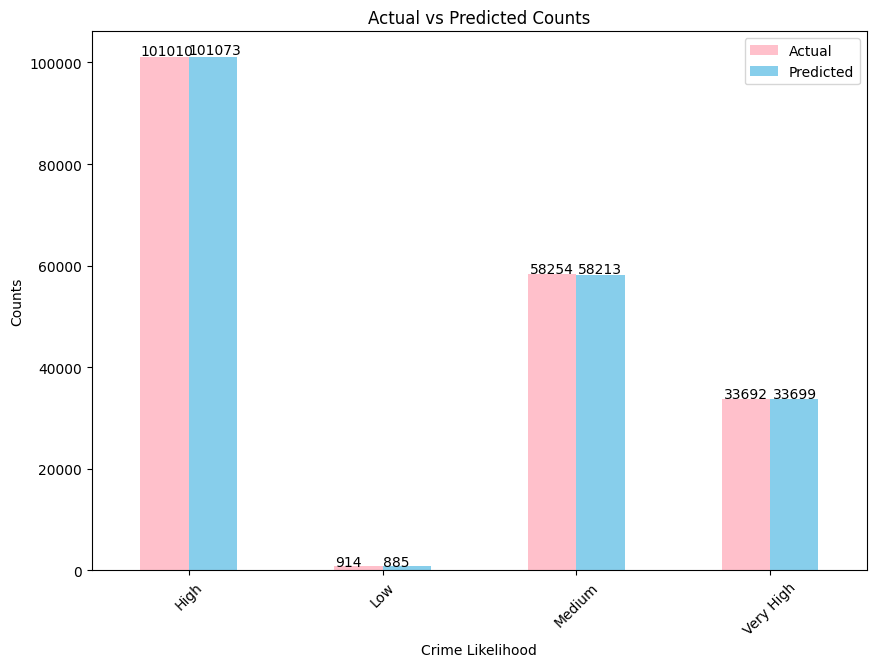

In [4]:
'''KNN Visualization''' 

#Plotting line plot
kValues = []
accuracies = []
possibleKValues = [2,5,8,10,25,50,70,100,150,220,340]

for i in possibleKValues:
    kValues.append(i)
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, Y_train)
    predKNN = model.predict(X_test)
    accuracies.append(accuracy_score(Y_test, predKNN))

plt.plot(kValues, accuracies)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_KNN)))

confMatrix = confusion_matrix(Y_test, Y_pred_KNN, labels=allRanges)

confMatrix_DF = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DF, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting bar chart
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_KNN).value_counts().reindex(allRanges, fill_value=0)

counts_df = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})

plt.figure(figsize=(12, 12))
countPlot = counts_df.plot(kind='bar', figsize=(10, 7), color=['pink', 'skyblue'])
plt.title('Actual vs Predicted Counts')
plt.ylabel('Counts')
plt.xlabel('Crime Likelihood')
plt.xticks(rotation=45)
plt.legend()

# Adding the value on the bars
for p in countPlot.patches:
    countPlot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()


In [5]:
'''Logistic Regression Model'''

#features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y= dataFrame['Crime Likelihood Range']

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

start_time = time.time()
#Training Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train,Y_train)

#Predictions on Testing data
Y_pred_LGR = logistic_model.predict(X_test)

execution_time_LGR = time.time() - start_time
print("Execution Time:", execution_time_LGR, "seconds")

#Evaluating performance
accuracy_LGR = accuracy_score(Y_test, Y_pred_LGR)
precision_LGR = precision_score(Y_test, Y_pred_LGR, average="weighted", zero_division=0) 
recall_LGR = recall_score(Y_test, Y_pred_LGR, average="weighted", zero_division=0) 
f1_LGR = f1_score(Y_test, Y_pred_LGR, average="weighted")
print("Logistic Regression Accuracy: ", accuracy_LGR)
print("Logistic Regression Precision: ", precision_LGR)
print("Logistic Regression Recall: ", recall_LGR)
print("Logistic Regression F1: ", f1_LGR)

/Users/nikhitapaluru/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Execution Time: 6.636335849761963 seconds
Logistic Regression Accuracy:  0.9395780677773766
Logistic Regression Precision:  0.9392290388767924
Logistic Regression Recall:  0.9395780677773766
Logistic Regression F1:  0.9392038037460988


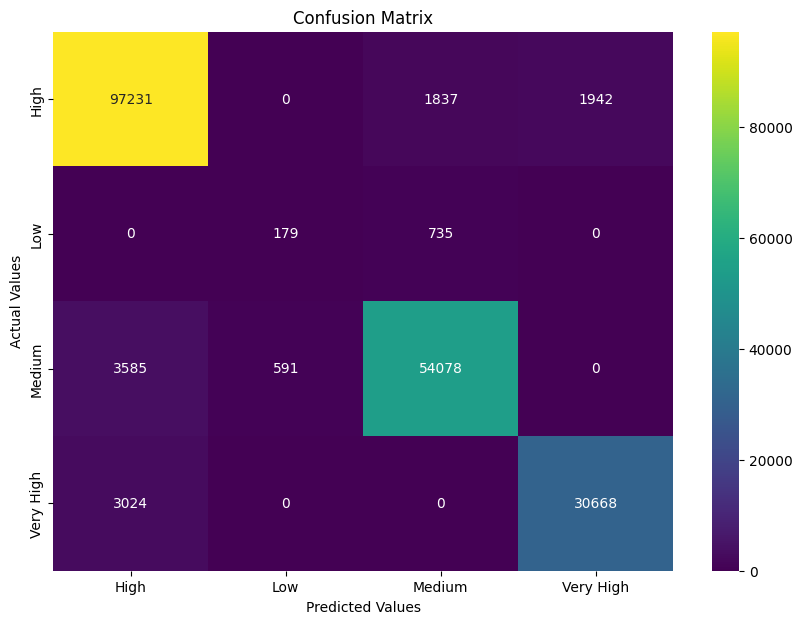

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2887464916.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (lineDF['Actual'][-1] - lineDF['Actual'][0]) / (lineDF['Predicted'][-1] - lineDF['Predicted'][0])
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2887464916.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f'Slope: {slope:.2f}', xy=(lineDF['Predicted'][2], lineDF['Actual'][2]), xytext=(lineDF['Predicted'][2]+10000, lineDF['Actual'][2]+5000),
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2887464916.py:33: UserWarning: No artists wi

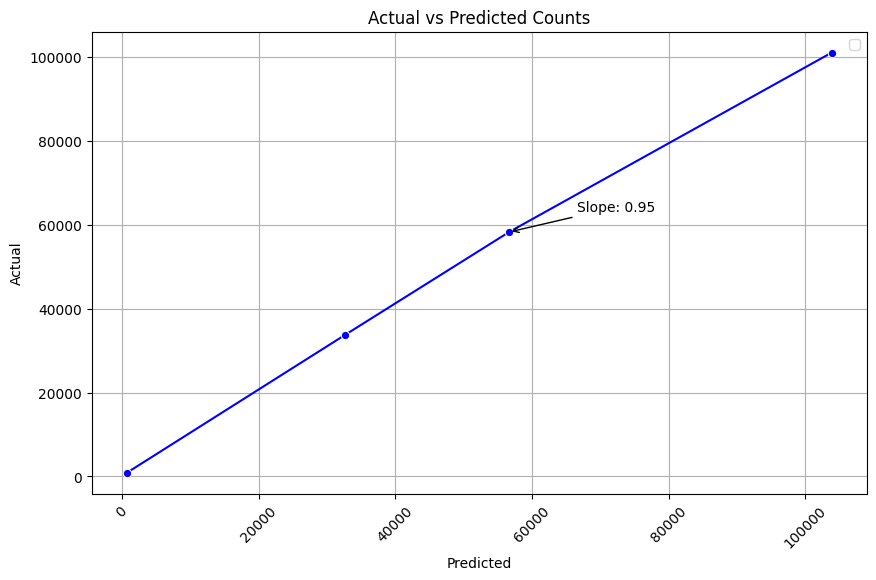

In [6]:
'''Logistic Regression Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_LGR)))

confMatrix = confusion_matrix(Y_test, Y_pred_LGR, labels=allRanges)

confMatrix_DF = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DF, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting line graph
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_LGR).value_counts().reindex(allRanges, fill_value=0)

lineDF = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})
plt.figure(figsize=(10, 6))
sns.lineplot(y='Actual', x='Predicted', data=lineDF, marker='o', color='b')
slope = (lineDF['Actual'][-1] - lineDF['Actual'][0]) / (lineDF['Predicted'][-1] - lineDF['Predicted'][0])

plt.annotate(f'Slope: {slope:.2f}', xy=(lineDF['Predicted'][2], lineDF['Actual'][2]), xytext=(lineDF['Predicted'][2]+10000, lineDF['Actual'][2]+5000),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Actual vs Predicted Counts')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True) 
plt.show()

In [7]:
'''Naive-Bayes Model'''

# features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y= dataFrame['Crime Likelihood Range']

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

start_time = time.time()
#Training Naive-Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, Y_train)

# Predictions on Testing data
Y_pred_NB = nb_model.predict(X_test)

execution_time_NB = time.time() - start_time
print("Execution Time:", execution_time_NB, "seconds")

#Evaluating performance
accuracy_NB = accuracy_score(Y_test, Y_pred_NB)
precision_NB = precision_score(Y_test, Y_pred_NB, average="weighted", zero_division=0)  
recall_NB = recall_score(Y_test, Y_pred_NB, average="weighted", zero_division=0) 
f1_NB = f1_score(Y_test, Y_pred_NB, average="weighted")
print("Naive-bayes Accuracy: ", accuracy_NB)
print("Naive-bayes Precision: ", precision_NB)
print("Naive-bayes Recall: ", recall_NB)
print("Naive-bayes F1: ", f1_NB)

Execution Time: 0.6994071006774902 seconds
Naive-bayes Accuracy:  0.5903543611698561
Naive-bayes Precision:  0.5830102540455511
Naive-bayes Recall:  0.5903543611698561
Naive-bayes F1:  0.5371988876050469


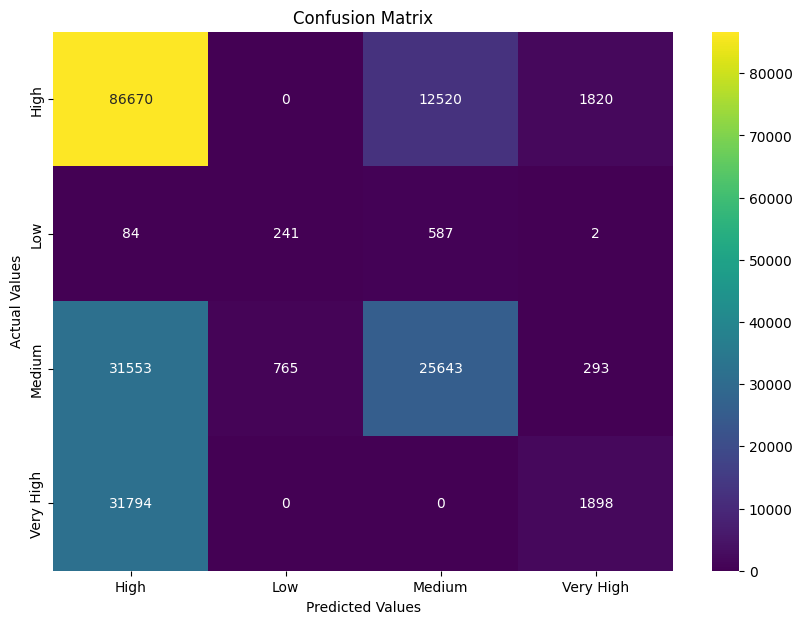

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/673555976.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


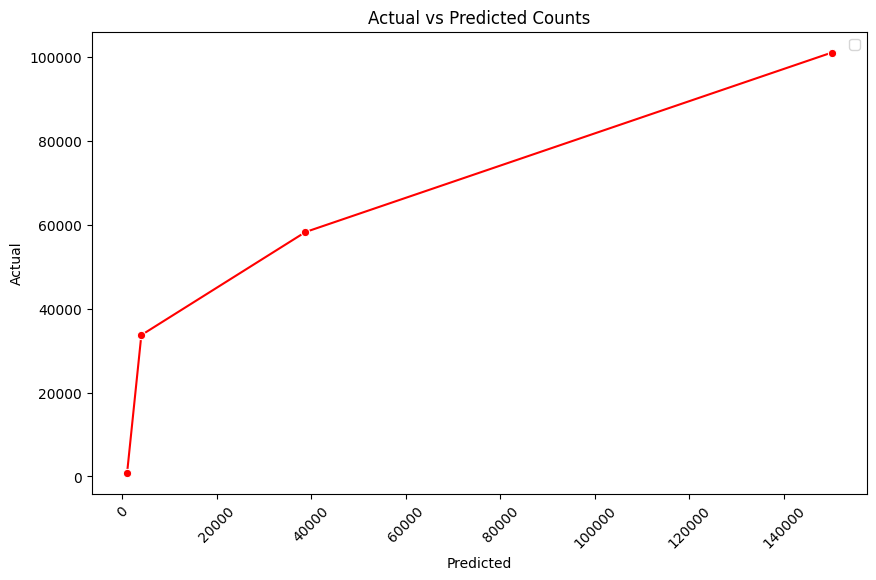

In [8]:
'''Naive-Bayes Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_NB)))

confMatrix = confusion_matrix(Y_test, Y_pred_NB, labels=allRanges)

confMatrix_DF = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DF, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting line graph
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_NB).value_counts().reindex(allRanges, fill_value=0)

lineDF = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})
plt.figure(figsize=(10, 6))
sns.lineplot(y='Actual', x='Predicted', data=lineDF, marker='o', color='r')

plt.title('Actual vs Predicted Counts')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.legend()
plt.grid(False) 
plt.show()

In [9]:
'''SVM model'''

# Features and target variable
X = dataFrame[['Age-Crime Ranking', 'Sex-Crime Ranking', 'Descent-Crime Ranking', 'Area-Crime Ranking', 'Time-Crime Ranking']]
Y = dataFrame['Crime Likelihood Range']

# Randomly split data (75% train, 25% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

start_time = time.time()
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM Model
svm_model = SVC(kernel='rbf') 
svm_model.fit(X_train_scaled, Y_train)

# Predictions on Testing data
Y_pred_SVM = svm_model.predict(X_test_scaled)

execution_time_SVM = time.time() - start_time
print("Execution Time:", execution_time_SVM, "seconds")

# Evaluate performance
accuracy_SVM = accuracy_score(Y_test, Y_pred_SVM)
precision_SVM = precision_score(Y_test, Y_pred_SVM, average="weighted", zero_division=0) 
recall_SVM = recall_score(Y_test, Y_pred_SVM, average="weighted", zero_division=0)
f1_SVM = f1_score(Y_test, Y_pred_SVM, average="weighted")
print("SVM Accuracy: ", accuracy_SVM)
print("SVM Precision: ", precision_SVM)
print("SVM Recall: ", recall_SVM)
print("SVM F1: ", f1_SVM)

Execution Time: 226.57718133926392 seconds
SVM Accuracy:  0.9993810285242688
SVM Precision:  0.999380733310976
SVM Recall:  0.9993810285242688
SVM F1:  0.9993802452733112


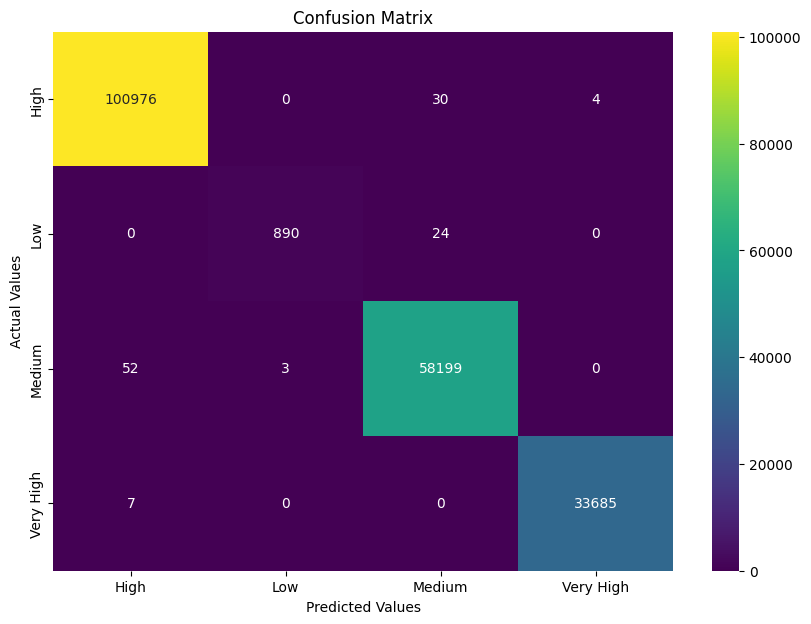

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/1286527787.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


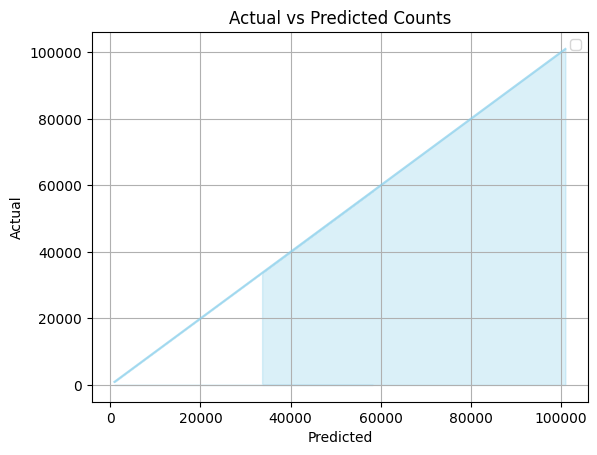

In [10]:
'''SVM Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_SVM)))

confMatrix = confusion_matrix(Y_test, Y_pred_SVM, labels=allRanges)

confMatrix_DF = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DF, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting area graph
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_SVM).value_counts().reindex(allRanges, fill_value=0)

sns.lineplot(x=predictedCount, y=actualCount, color='skyblue', alpha=0.7)
plt.fill_between(predictedCount, actualCount, color='skyblue', alpha=0.3)  

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs Predicted Counts')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
'''Random Forest Model'''

# features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y= dataFrame['Crime Likelihood Range']

le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y_encoded,test_size=0.25,random_state=42)

start_time = time.time()
#Training Random forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, Y_train)

# Predictions on Testing data
Y_pred_RF = rf_model.predict(X_test)

execution_time_RF = time.time() - start_time
print("Execution Time:", execution_time_RF, "seconds")

#Evaluating performance
accuracy_RF = accuracy_score(Y_test, Y_pred_RF)
precision_RF = precision_score(Y_test, Y_pred_RF, average="weighted", zero_division=0) 
recall_RF = recall_score(Y_test, Y_pred_RF, average="weighted", zero_division=0) 
f1_RF = f1_score(Y_test, Y_pred_RF, average="weighted")
print("RF Accuracy: ", accuracy_RF)
print("RF Precision: ", precision_RF)
print("RF Recall: ", recall_RF)
print("RF F1: ", f1_RF)


Execution Time: 12.602418899536133 seconds
RF Accuracy:  0.9997111466446588
RF Precision:  0.9997108691564734
RF Recall:  0.9997111466446588
RF F1:  0.9997107249510293


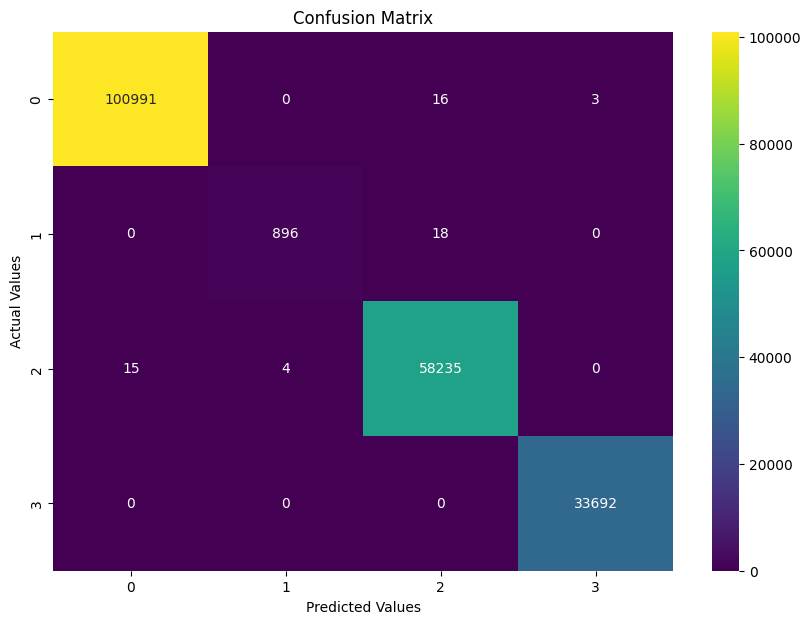

<Figure size 1200x1200 with 0 Axes>

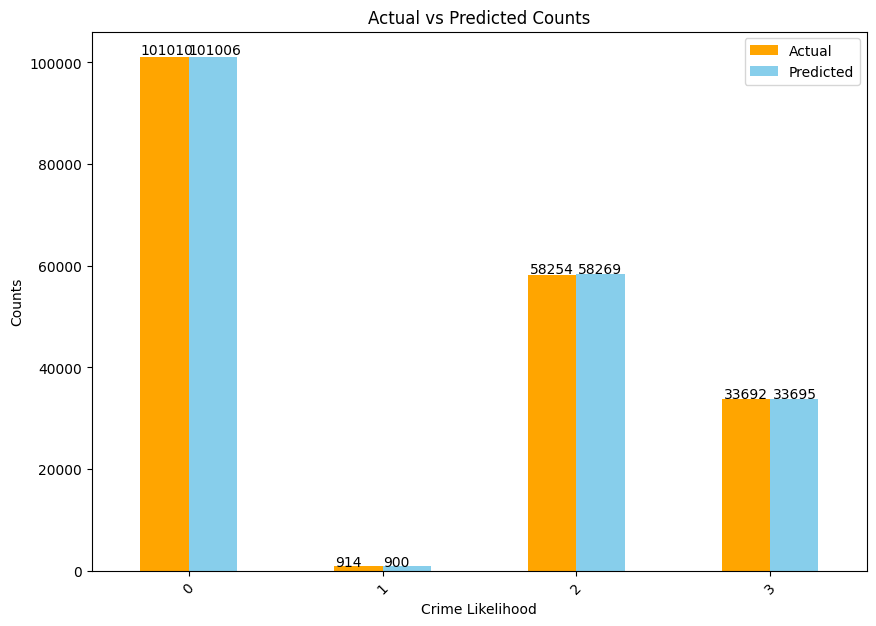

In [12]:
'''Random Forest Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_RF)))

confMatrix = confusion_matrix(Y_test, Y_pred_RF, labels=allRanges)

confMatrix_DF = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DF, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting bar chart
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_RF).value_counts().reindex(allRanges, fill_value=0)

counts_df = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})

plt.figure(figsize=(12, 12))
countPlot = counts_df.plot(kind='bar', figsize=(10, 7), color=['orange', 'skyblue'])
plt.title('Actual vs Predicted Counts')
plt.ylabel('Counts')
plt.xlabel('Crime Likelihood')
plt.xticks(rotation=45)
plt.legend()

# Adding the value on the bars
for p in countPlot.patches:
    countPlot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [13]:
'''Gradient Boosting Model'''

# features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y= dataFrame['Crime Likelihood Range']

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

start_time = time.time()
#Training Random forest model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=3)
gb_model.fit(X_train, Y_train)

# Predictions on Testing data
Y_pred_GB = gb_model.predict(X_test)

execution_time_GB = time.time() - start_time
print("Execution Time:", execution_time_GB, "seconds")

#Evaluating performance
accuracy_GB = accuracy_score(Y_test, Y_pred_GB)
precision_GB = precision_score(Y_test, Y_pred_GB, average="weighted", zero_division=0)  
recall_GB = recall_score(Y_test, Y_pred_GB, average="weighted", zero_division=0)  
f1_GB = f1_score(Y_test, Y_pred_GB, average="weighted")
print("GB Accuracy: ", accuracy_GB)
print("GB Precision: ", precision_GB)
print("GB Recall: ", recall_GB)
print("GB F1: ", f1_GB)

Execution Time: 55.55608582496643 seconds
GB Accuracy:  0.9668695517614897
GB Precision:  0.9676187811965922
GB Recall:  0.9668695517614897
GB F1:  0.9667874132949639


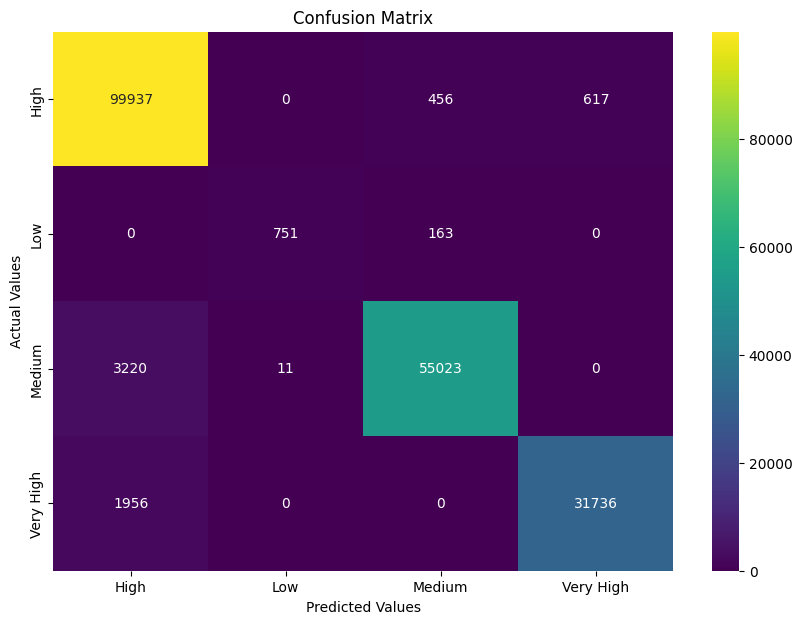

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/251867261.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (LineGB['Actual'][-1] - LineGB['Actual'][0]) / (LineGB['Predicted'][-1] - LineGB['Predicted'][0])
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/251867261.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f'Slope: {slope:.2f}', xy=(LineGB['Predicted'][2], LineGB['Actual'][2]), xytext=(LineGB['Predicted'][2]+10000, LineGB['Actual'][2]+5000),
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/251867261.py:34: UserWarning: No artists with 

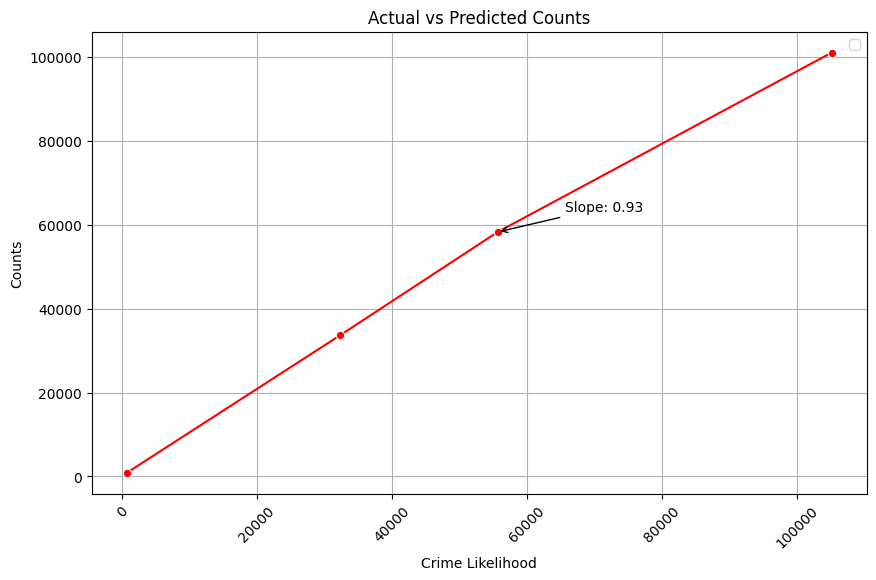

In [14]:
'''Gradient Boosting Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_GB)))

confMatrix = confusion_matrix(Y_test, Y_pred_GB, labels=allRanges)

confMatrix_DT = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DT, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting line graph
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_GB).value_counts().reindex(allRanges, fill_value=0)

LineGB = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})
plt.figure(figsize=(10, 6))
sns.lineplot(y='Actual', x='Predicted', data=LineGB, marker='o', color='r')
slope = (LineGB['Actual'][-1] - LineGB['Actual'][0]) / (LineGB['Predicted'][-1] - LineGB['Predicted'][0])

plt.annotate(f'Slope: {slope:.2f}', xy=(LineGB['Predicted'][2], LineGB['Actual'][2]), xytext=(LineGB['Predicted'][2]+10000, LineGB['Actual'][2]+5000),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Actual vs Predicted Counts')
plt.ylabel('Counts')
plt.xlabel('Crime Likelihood')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [15]:
'''Decision Tree Model'''

# features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y = dataFrame['Crime Likelihood Range']

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

start_time = time.time()
#Training Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, Y_train)

# Predictions on Testing data
Y_pred_DT = dt_model.predict(X_test)

execution_time_DT = time.time() - start_time
print("Execution Time:", execution_time_DT, "seconds")

#Evaluating performance
accuracy_DT = accuracy_score(Y_test, Y_pred_DT)
precision_DT = precision_score(Y_test, Y_pred_DT, average="weighted", zero_division=0) 
recall_DT = recall_score(Y_test, Y_pred_DT, average="weighted", zero_division=0) 
f1_DT = f1_score(Y_test, Y_pred_DT, average="weighted")
print("Decision Tree Accuracy: ", accuracy_DT)
print("Decision Tree Precision: ", precision_DT)
print("Decision Tree Recall: ", recall_DT)
print("Decision Tree F1: ", f1_DT)


Execution Time: 0.5598042011260986 seconds
Decision Tree Accuracy:  0.9997472533140764
Decision Tree Precision:  0.9997473661322144
Decision Tree Recall:  0.9997472533140764
Decision Tree F1:  0.9997473028875281


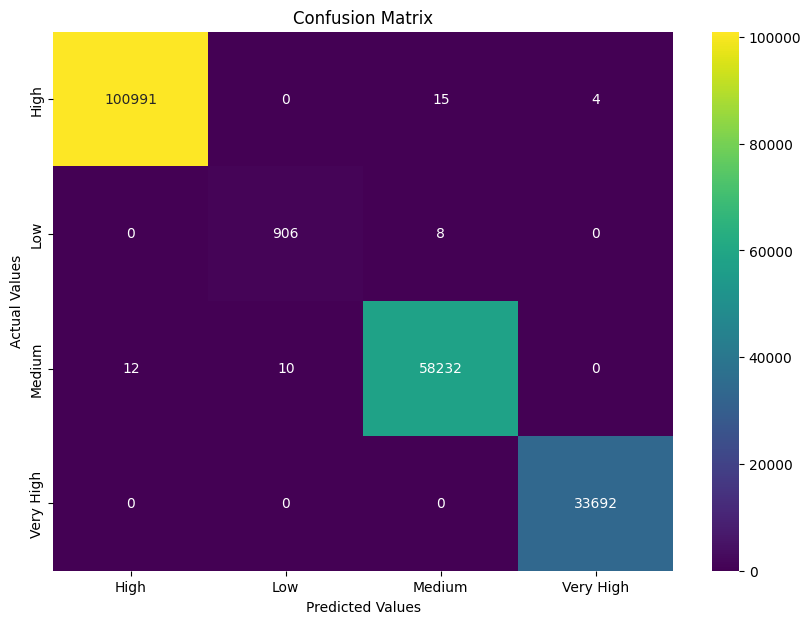

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2375202891.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (LineDt['Actual'][-1] - LineDt['Actual'][0]) / (LineDt['Predicted'][-1] - LineDt['Predicted'][0])
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2375202891.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(f'Slope: {slope:.2f}', xy=(LineDt['Predicted'][2], LineDt['Actual'][2]), xytext=(LineDt['Predicted'][2]+10000, LineDt['Actual'][2]+5000),
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/2375202891.py:34: UserWarning: No artists wi

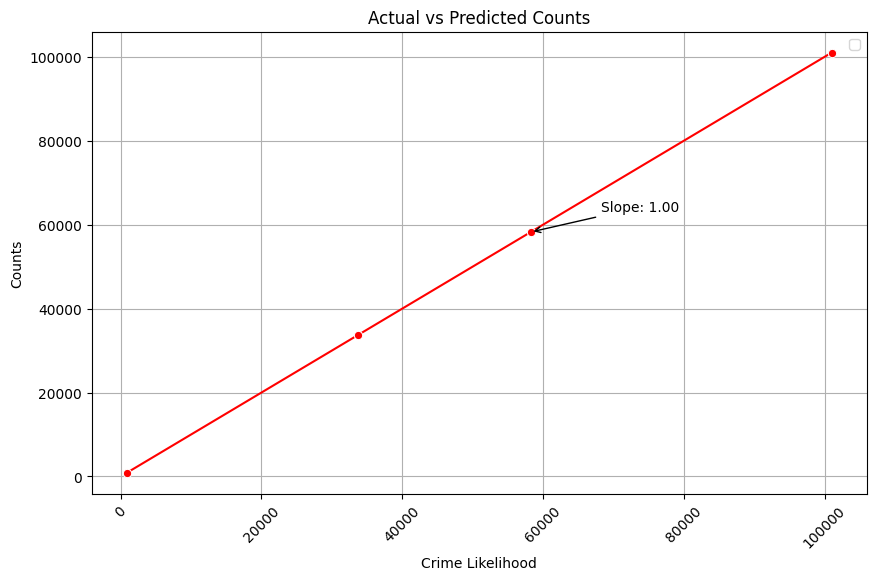

In [16]:
'''Decision Tree Visualization''' 

# Plotting confusion matrix as a heatmap
allRanges = np.unique(np.concatenate((Y_test, Y_pred_DT)))

confMatrix = confusion_matrix(Y_test, Y_pred_DT, labels=allRanges)

confMatrix_DT = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_DT, annot=True, fmt='g', cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting line graph
actualCount = pd.Series(Y_test).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_DT).value_counts().reindex(allRanges, fill_value=0)

LineDt = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})
plt.figure(figsize=(10, 6))
sns.lineplot(y='Actual', x='Predicted', data=LineDt, marker='o', color='r')
slope = (LineDt['Actual'][-1] - LineDt['Actual'][0]) / (LineDt['Predicted'][-1] - LineDt['Predicted'][0])

plt.annotate(f'Slope: {slope:.2f}', xy=(LineDt['Predicted'][2], LineDt['Actual'][2]), xytext=(LineDt['Predicted'][2]+10000, LineDt['Actual'][2]+5000),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Actual vs Predicted Counts')
plt.ylabel('Counts')
plt.xlabel('Crime Likelihood')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
'''XGBoost Model'''

#features and target variable
X = dataFrame[['Age-Crime Ranking','Sex-Crime Ranking','Descent-Crime Ranking','Area-Crime Ranking','Time-Crime Ranking']]
Y = dataFrame['Crime Likelihood Range']

le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Random splitting data(75% , 25%)
X_train , X_test, Y_train , Y_test = train_test_split(X,Y_encoded,test_size=0.25,random_state=42)

start_time = time.time()

#Training XGB Model
xgb_model = XGBClassifier(objective='multi:softmax', num_class=5, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, Y_train)

#Predictions on Testing data
Y_pred_XGB = xgb_model.predict(X_test)

execution_time_XGB = time.time() - start_time
print("Execution Time:", execution_time_XGB, "seconds")

#Evaluating performance
accuracy_XGB = accuracy_score(Y_test, Y_pred_XGB)
precision_XGB = precision_score(Y_test, Y_pred_XGB, average="weighted", zero_division=0)  
recall_XGB = recall_score(Y_test, Y_pred_XGB, average="weighted", zero_division=0) 
f1_XGB = f1_score(Y_test, Y_pred_XGB, average="weighted")
print("XGB Accuracy: ", accuracy_XGB)
print("XGB Precision: ", precision_XGB)
print("XGB Recall: ", recall_XGB)
print("XGB F1: ", f1_XGB)


/Users/nikhitapaluru/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [23:13:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Execution Time: 3.3436076641082764 seconds
XGB Accuracy:  0.9992984989941713
XGB Precision:  0.9992983219214819
XGB Recall:  0.9992984989941713
XGB F1:  0.9992980282711079


['model.pkl']

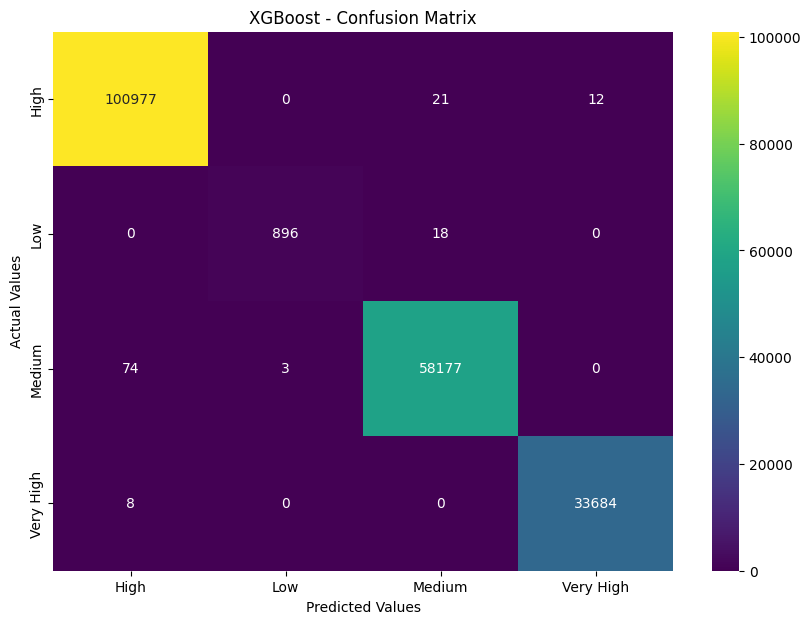

/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/1453954363.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (LineXGB['Actual'][-1] - LineXGB['Actual'][0]) / (LineXGB['Predicted'][-1] - LineXGB['Predicted'][0])
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/1453954363.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(LineXGB['Predicted'][2], LineXGB['Actual'][2]),
/var/folders/z4/372y5m2d59lgykyq9y4l02pw0000gn/T/ipykernel_22529/1453954363.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

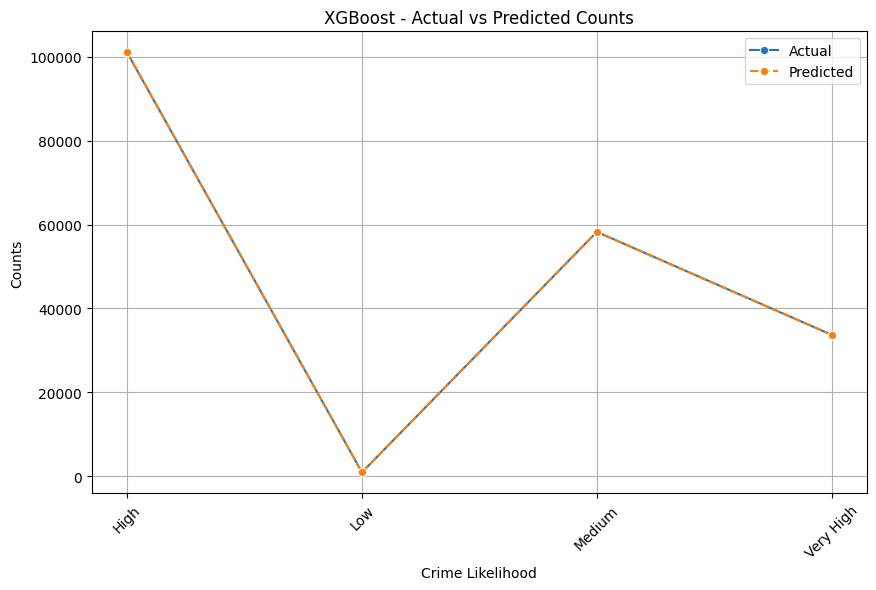

In [18]:
'''XGBoost Visualization''' 

Y_test_labels = le.inverse_transform(Y_test)
Y_pred_labels = le.inverse_transform(Y_pred_XGB)

# Plotting Confusion Matrix as a Heatmap
allRanges = np.unique(np.concatenate((Y_test_labels, Y_pred_labels)))

confMatrix = confusion_matrix(Y_test_labels, Y_pred_labels, labels=allRanges)
confMatrix_XGB = pd.DataFrame(confMatrix, index=allRanges, columns=allRanges)

plt.figure(figsize=(10, 7))
sns.heatmap(confMatrix_XGB, annot=True, fmt='g', cmap='viridis')
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Plotting Line Graph
actualCount = pd.Series(Y_test_labels).value_counts().reindex(allRanges, fill_value=0)
predictedCount = pd.Series(Y_pred_labels).value_counts().reindex(allRanges, fill_value=0)

LineXGB = pd.DataFrame({'Actual': actualCount, 'Predicted': predictedCount})

plt.figure(figsize=(10, 6))
sns.lineplot(data=LineXGB, marker='o')
plt.title('XGBoost - Actual vs Predicted Counts')
plt.ylabel('Counts')
plt.xlabel('Crime Likelihood')
plt.xticks(rotation=45)
plt.grid(True)

try:
    slope = (LineXGB['Actual'][-1] - LineXGB['Actual'][0]) / (LineXGB['Predicted'][-1] - LineXGB['Predicted'][0])
    plt.annotate(f'Slope: {slope:.2f}',
                 xy=(LineXGB['Predicted'][2], LineXGB['Actual'][2]),
                 xytext=(LineXGB['Predicted'][2]+1, LineXGB['Actual'][2]+1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
except Exception as e:
    print("Slope annotation skipped due to error:", e)

plt.legend()
plt.show()


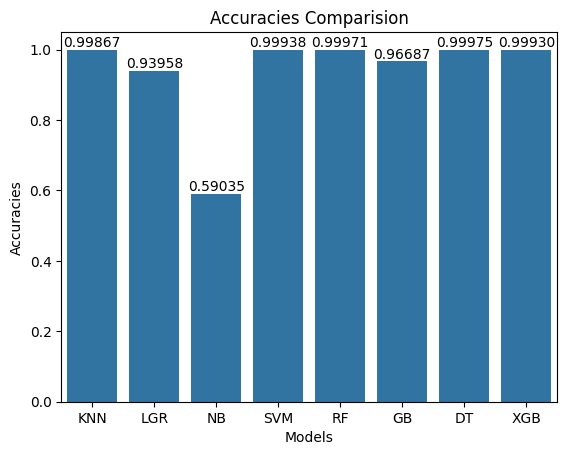

In [21]:
'''Accuracies Comparision Plot'''
modelNames=["KNN","LGR","NB","SVM","RF","GB","DT","XGB"]

model_accuracies=[accuracy_KNN,accuracy_LGR,accuracy_NB,accuracy_SVM,accuracy_RF,accuracy_GB,accuracy_DT,accuracy_XGB]

plot= sns.barplot(x=modelNames,y=model_accuracies)
plt.title('Accuracies Comparision')
plt.xlabel("Models") 
plt.ylabel("Accuracies")

for i, v in enumerate(model_accuracies):
    plot.text(i, v, f'{v:.5f}', ha='center', va='bottom')

plt.savefig("../static/accuracies.jpeg", dpi=300, bbox_inches='tight')
plt.show()

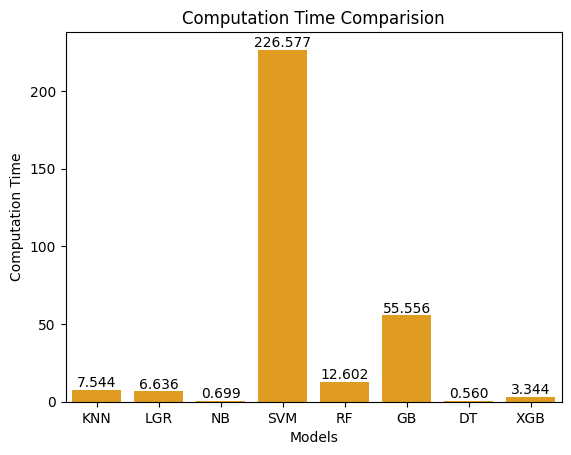

In [22]:
'''Computation Time Plot'''
computation_times = [execution_time_KNN, execution_time_LGR, execution_time_NB, execution_time_SVM, execution_time_RF, execution_time_GB, execution_time_DT,execution_time_XGB]

plot= sns.barplot(x=modelNames,y=computation_times, color='orange')
plt.title('Computation Time Comparision')
plt.xlabel("Models")
plt.ylabel("Computation Time")

for i, v in enumerate(computation_times):
    plot.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.savefig("../static/computations.jpeg", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
models = [knn_model, logistic_model, nb_model, svm_model, rf_model, gb_model, dt_model, xgb_model]
modelNamesFull = ["K-Nearest Neighbors", "Logistic Regression", "Naive Bayes", "Support Vector Machine", "Random Forest", "Gradient Boosting", "Decision Tree", "Extreme Gradient Boosting (XGBoost)"]

maxAcc = max(model_accuracies)
bestAccIdxs = [i for i, acc in enumerate(model_accuracies) if acc == maxAcc]

bestIdx = min(bestAccIdxs, key=lambda i: computation_times[i])

bestModel = models[bestIdx]
bestModelName = modelNamesFull[bestIdx]

dump(bestModel, "model.pkl")

print(bestAccIdxs)
with open("modelName.txt", "w") as f:
    f.write(bestModelName)


[6]
